In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from statsmodels.tsa.stattools import adfuller
import arviz as az # Import arviz to handle the trace object
import warnings
warnings.filterwarnings("ignore")


In [42]:
df=pd.read_csv('../Data/BrentOilPrices.csv')

In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [44]:
def plot_raw_data(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Price'], label='Brent Oil Price')
    plt.title('Brent Oil Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

In [45]:
# Perform ADF Test for Stationarity
def adf_test(data):
    adf_result = adfuller(data['Price'])
    print(f'ADF Statistic: {adf_result[0]:.2f}')
    print(f'p-value: {adf_result[1]:.4f}')
    return adf_result[1] < 0.05  # True if stationary

# Bayesian Change Point Model
def change_point_model(data):
    prices = data['Price'].values
    with pm.Model() as model:
        tau = pm.DiscreteUniform('tau', lower=0, upper=len(prices) - 1)
        mu_1 = pm.Normal('mu_1', mu=prices.mean(), sigma=10)
        mu_2 = pm.Normal('mu_2', mu=prices.mean(), sigma=10)
        sigma_1 = pm.HalfNormal('sigma_1', sigma=10)
        sigma_2 = pm.HalfNormal('sigma_2', sigma=10)
        idx = np.arange(len(prices))
        mu = pm.Deterministic('mu', pm.math.switch(idx < tau, mu_1, mu_2))
        sigma = pm.Deterministic('sigma', pm.math.switch(idx < tau, sigma_1, sigma_2))
        likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=prices)
        trace = pm.sample(2000, tune=1000, target_accept=0.95, cores=1)
    return model, trace

In [ ]:
# Plotting the model's fitted means
def plot_fitted_model(data, trace, model):
    tau_mean = int(np.mean(trace.posterior['tau'].values.flatten()))
    mu_1_mean = np.mean(trace.posterior['mu_1'].values.flatten())
    mu_2_mean = np.mean(trace.posterior['mu_2'].values.flatten())
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Price'], 'k.', label='Observed Prices', alpha=0.5)
    
    # Plot the mean before the change point
    plt.axvline(x=data.index[tau_mean], color='r', linestyle='--', label='Estimated Change Point')
    plt.hlines(mu_1_mean, xmin=data.index[0], xmax=data.index[tau_mean], color='b', linestyle='-', label='Mean Before Change')
    plt.hlines(mu_2_mean, xmin=data.index[tau_mean], xmax=data.index[-1], color='g', linestyle='-', label='Mean After Change')
    
    plt.title('Brent Oil Price with Estimated Change Point and Means')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

In [ ]:
# Plotting Change Point Results
def plot_change_points(trace):
    tau_samples = trace.posterior['tau'].values.flatten()
    
    plt.figure(figsize=(10, 5))
    plt.hist(tau_samples, bins=30, alpha=0.5)
    plt.xlabel('Change Point (tau)')
    plt.ylabel('Frequency')
    plt.title('Posterior Distribution of Change Point')
    plt.show()

--- Task 2.1: Core Analysis ---
Step 1: Data Preparation and EDA


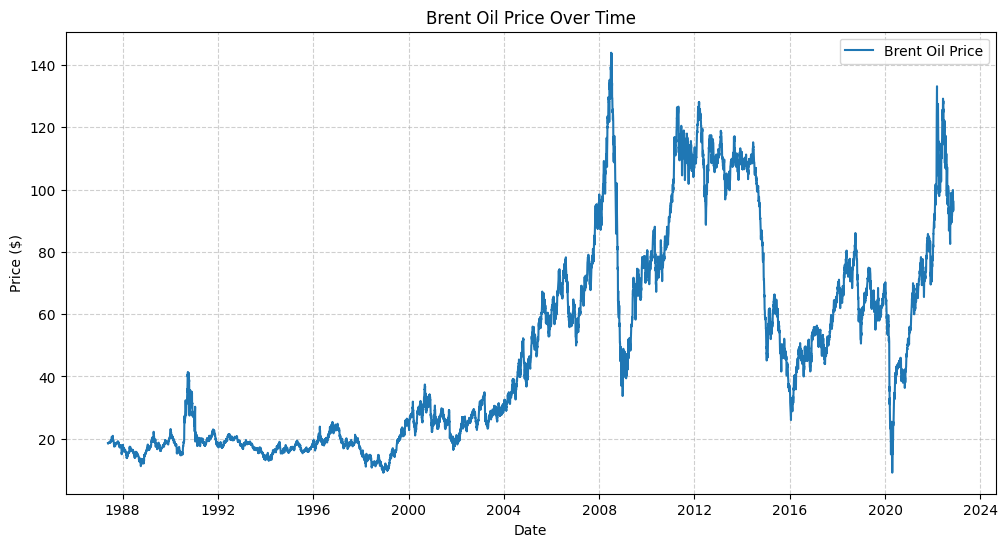

ADF Statistic: -1.99
p-value: 0.2893
Stationary: False

Step 2: Building and Fitting Bayesian Change Point Model...


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model fitting complete.

Step 3: Interpreting the Model Output
Checking for convergence...


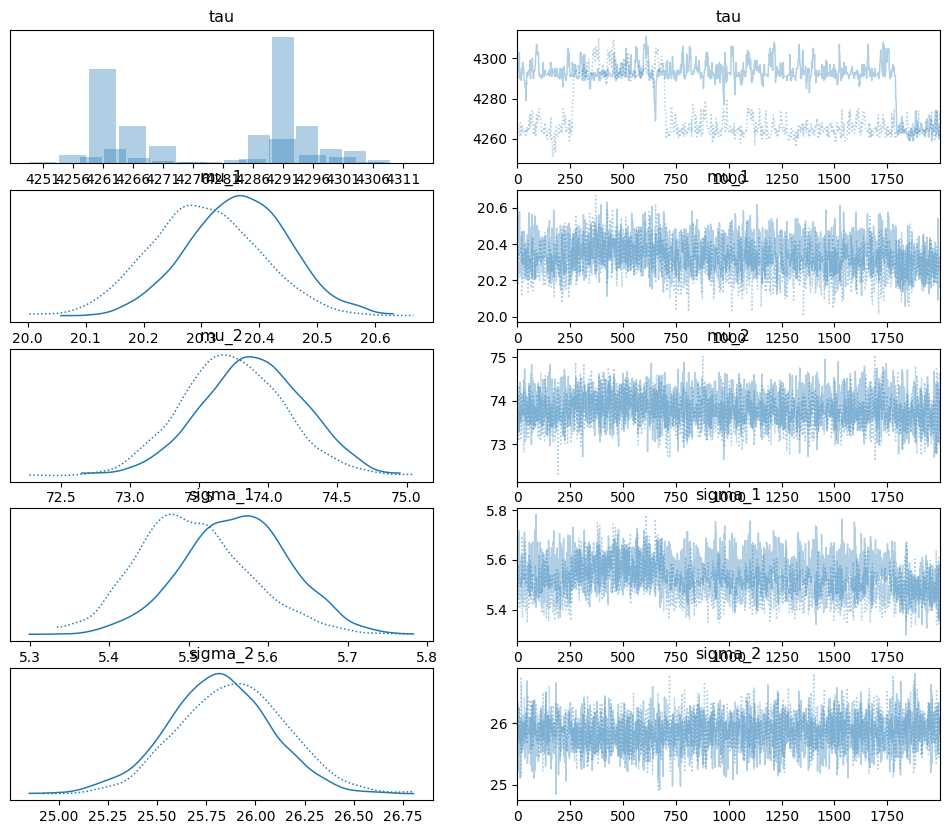

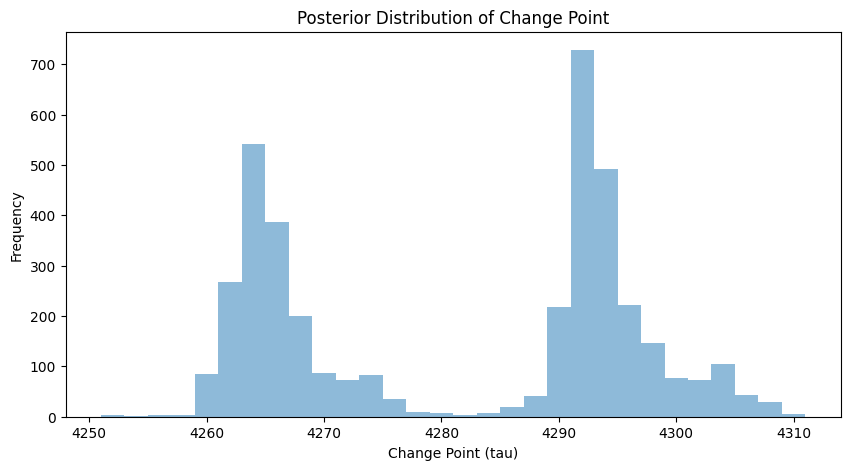

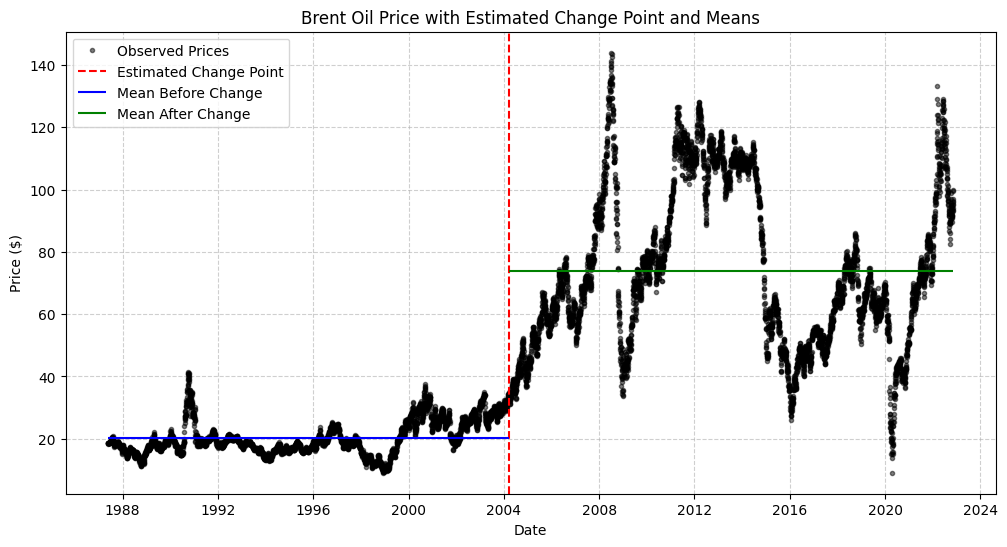

Estimated Change Point Index: 4281
Estimated Change Point Date: 2004-03-24 00:00:00
Average Price Before Change: $20.33
Average Price After Change: $73.84
Percentage Change: 263.13%

Step 4: Associating Changes with Causes
Note: The change point on 2004-03-24 is not a direct match for the OPEC Cut event on 2020-04-12.
Note: The change point on 2004-03-24 is not a direct match for the COVID-19 Pandemic event on 2020-03-01.

--- Task 2.2: Advanced Extensions ---
Exploring Other Potential Factors: To build a more comprehensive model, one could incorporate other time series data like macroeconomic indicators (e.g., GDP, inflation rates) or exchange rates. This would involve a more complex model, such as a multivariate change point model, to analyze the joint dynamics.
Considering Advanced Models: Other models could provide different insights. A Vector Autoregression (VAR) model could be used to analyze the dynamic relationship between oil prices and a basket of macroeconomic variables. Alt

In [ ]:
# Main Execution
if __name__ == "__main__":
    # Part 2.1: Core Analysis
    print("--- Task 2.1: Core Analysis ---")
    
    # Step 1: Data Preparation and EDA
    print("Step 1: Data Preparation and EDA")
    plot_raw_data(df)
    
    # Perform stationarity test
    is_stationary = adf_test(df)
    print(f'Stationary: {is_stationary}\n')

    # Step 2: Building the Bayesian Change Point Model
    print("Step 2: Building and Fitting Bayesian Change Point Model...")
    model, trace = change_point_model(df)
    print("Model fitting complete.")

    # Step 3: Interpreting the Model Output
    print("\nStep 3: Interpreting the Model Output")
    # Check for convergence
    print("Checking for convergence...")
    az.summary(trace, var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'])
    az.plot_trace(trace, var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'])
    plt.show()

    # Plot the posterior distribution of the change point
    plot_change_points(trace)
    
    # Plot the raw data with the fitted model
    plot_fitted_model(df, trace, model)

    # Identify and quantify the impact of change points
    change_point_estimate = np.mean(trace.posterior['tau'].values.flatten())
    estimated_index = int(round(change_point_estimate))
    estimated_date = df.index[estimated_index]
    
    print(f'Estimated Change Point Index: {estimated_index}')
    print(f'Estimated Change Point Date: {estimated_date}')

    before_change = df['Price'].iloc[:estimated_index].mean()
    after_change = df['Price'].iloc[estimated_index:].mean()
    percentage_change = ((after_change - before_change) / before_change) * 100

    print(f'Average Price Before Change: ${before_change:.2f}')
    print(f'Average Price After Change: ${after_change:.2f}')
    print(f'Percentage Change: {percentage_change:.2f}%')

    # Associate changes with causes
    events = {
        "OPEC Cut": "2020-04-12",
        "COVID-19 Pandemic": "2020-03-01"
    }
    
    print("\nStep 4: Associating Changes with Causes")
    for event, date_str in events.items():
        event_date = pd.to_datetime(date_str)
        # Check if the estimated date is within a reasonable window of the event
        if (event_date - pd.Timedelta(days=30)) <= estimated_date <= (event_date + pd.Timedelta(days=30)):
            print(f'Change point on {estimated_date.date()} is likely associated with {event}.')
        else:
            print(f'Note: The change point on {estimated_date.date()} is not a direct match for the {event} event on {event_date.date()}.')
